# Pruebas del método de volumen finito
- Óscar Alvarado
- Oscar Esquivel
- Jose Porras

In [1]:
import numpy as np
import plotly.graph_objects as go
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

## Índice

1. [Mallado](#Mallado)
2. [Mallado escalonado](#Staggered-grids)
3. [SIMPLE](#SIMPLE)
4. [Coeficientes](#Coeficientes)
5. [Difusión](#Difusión)
6. [Convección](#Convección)
7. [Sistema de ecuaciones](#Sistema-de-ecuaciones)
8. [Problemas](#Problemas)
    - [Una dimensión](#Una-dimensión)
    - [Una dimensión, no uniformidad](#Una-dimensión,-no-uniformidad)
    - [Una dimensión con convección](#Una-dimensión-con-convección)
    - [Dos dimensiones](#Dos-dimensiones)
    - [Tres dimensiones](#Tres-dimensiones)
10. [Condiciones iniciales](#Problema-condiciones-iniciales)

## Mallado

In [2]:
class Mesh():
    """
    Clase del mallado
    """
    def __init__(self, dim, volumes = None, lengths = None):
        """
        Constructor de la clase Malla.
        """

        self.volumes = (1,1,1)
        self.lengths = (0.01, 0.01, 0.01)

        #----default values for positions and separations of the grid-------------
        self.coords = [(0.005,) for _ in range(3)] # Coordenadas de los centros de los volúmenes
        self.dominios = [tuple([0.]+[self.coords[i][0]]+[self.lengths[i]]) for i in range(3)]
        self.deltas = [(0,) for _ in range(3)]
        # Hasta aquí tenemos un cubito

        self.__tags = {} # El etiquetado de todos los nodos sin fronteras
        self.__tags_fronteras = {} # El etiquetado de las fronteras
        
        self.dim = dim
        if isinstance(volumes, int):  self.volumes = (volumes, 1, 1)
        if isinstance(lengths, (int, float)):  self.lengths = (lengths, lengths/10, lengths/10)
        
        # Si los parámetros son tuplas (pero no necesariamente sería una tupla de 3), arreglamos eso:
        if isinstance(volumes, tuple):
            faltan = 3 - len(volumes)
            self.volumes = volumes + tuple([1 for i in range(faltan)])
        if isinstance(lengths, tuple): 
            faltan = 3 - len(lengths)
            self.lengths = lengths + tuple([lengths[0]/10 for i in range(faltan)])
        #---------------------------------------------------------------
        
        # if volumes and lengths are given, initialize values acording to dimension
        if (volumes and lengths):       
            self.uniform_grid()
            self.init_tags()
            self.init_tags_fronteras()
    
    
    def uniform_grid(self):
        l = np.array(self.lengths) # Para el manejo con numpy
        v = np.array(self.volumes)
        d = l/v # Separación entre todos los nodos de cada dimensión
        start = d/2 # La frontera "inicial" del arreglo
        stop = l-d/2 # La frontera "final" del arreglo
        self.coords = [tuple(np.linspace(strt, stp, vol)) \
                       for strt, stp, vol in list(zip(start, stop, v))] # Meshgrid posible
        dominios = [np.insert(arr,(0,len(arr)),[0, l[idx]]) \
                    for idx, arr in enumerate(self.coords)] # Coordenadas + fronteras
        # Separación entre los nodos (Aquí hay que ver cómo es cuando tenemos un grid 
        # de 2x1x1 ya cuando se haga el FVM
        self.deltas = [self.set_deltas(dom)  if len(self.set_deltas(dom)) != 0 \
                       else (dom[-1],) for dom in dominios]
        self.dominios = [tuple(dom) for dom in dominios]
        #self.faces = [tuple((np.array(coords[:-1]) + np.array(coords[1:]))/2) for coords in self.coords]
        self.faces = [(self.dominios[idx][0],) + tuple((np.array(coords[:-1]) + np.array(coords[1:]))/2) \
                          + (self.dominios[idx][-1],) for idx, coords in enumerate(self.coords)]
        self.get_deltas_faces()
        self.get_grids()
    
    
    def set_deltas(self, dominio):
        """
        Método para obtener la distancia que hay entre los nodos
        """
        return tuple((dominio[1:]-dominio[:-1])[1:-1])


    # Creo que esto no se usará, pero estuvo chida la deducción, lo dejo de todos modos xd
    #def totalDomNodes(self):
    #    d_1 = 6*self.volumes[0] + 1
    #    d_2 = self.volumes[1]*d_1 - self.volumes[0]*(self.volumes[1] - 1)
    #    d_3 = self.volumes[2]*d_2 - self.volumes[0]*self.volumes[1]*(self.volumes[2] - 1)
    #    return d_3
    
    def init_tags(self):
        """
        Método que etiqueta las caras adyacentes de cada volumen dependiendo de la geometría. Pone un {} 
        (diccionario vacío) cuando es una frontera, una 'F' cuando es una cara interna y un 'Off' cuando 
        no se está contando esa cara por las dimensiones del problema. 
        """
        self.__tags = {}
        X, Y, Z = self.volumes
        for z in range(1,Z+1):
            for y in range(1,Y+1):
                for x in range(1,X+1):                   
                    t = b = n = s = "Off"
                    e = w = "F"
                    if x == 1: w = {}
                    elif x == X: e = {}
                    if self.dim > 1:
                        n = s = "F"
                        if y == 1: n = {}
                        elif y == Y: s = {}
                        if self.dim == 3:
                            t = b = "F"
                            if z == 1: t = {}
                            elif z == Z: b = {}
                    self.__tags[f"{x}-{y}-{z}"] = {"E": e, "W": w, "N": n, "S": s, "T": t, "B": b, 
                                             "coord": [self.dominios[0][x], self.dominios[1][y], 
                                                       self.dominios[2][z]]}
    
    def init_tags_fronteras(self):
        """
        Método para etiquetar las fronteras dependiendo de la dimensión, sólo se les da la propiedad de 
        existir o no existir.
        """
        self.__tags_fronteras = {}
        X, Y, Z = [len(dom) for dom in self.dominios]
        for z in range(Z):
            for y in range(Y):
                for x in range(X):
                    t = b = n = s = "Off"
                    e = w = "ON"
                    if self.dim > 1: 
                        n = s = "ON"
                        if self.dim == 3: t = b = "ON"
                    # El siguiente cacho de código es para saber si nos encontramos con una frontera
                    if x==0 or y==0 or z==0 or x==(X-1) or y==(Y-1) or z==(Z-1):
                        var = None
                        if y != 0 and y != (Y - 1):
                            if z != 0 and z != (Z - 1):
                                if x == 0: var = "W"; value = w
                                elif x == (X - 1): var = "E"; value = e
                                else: continue
                            elif x != 0 and x != (X - 1):
                                if z == 0: var = "T"; value = t
                                elif z == (Z - 1): var = "B"; value = b
                                else: continue
                            else: continue
                            self.__tags_fronteras[f"{x}-{y}-{z}"] = {"frontera": {var: value},
                                                 "coord": [self.dominios[0][x], self.dominios[1][y],
                                                           self.dominios[2][z]], "cond": {}} 
                        elif z != 0 and z != (Z - 1):
                            if x != 0 and x != (X - 1):
                                if y == 0: var = "N"; value = n
                                elif y == (Y - 1) : var = "S"; value = s
                                self.__tags_fronteras[f"{x}-{y}-{z}"] = {"frontera": {var: value},
                                                 "coord": [self.dominios[0][x], self.dominios[1][y], 
                                                           self.dominios[2][z]], "cond": {}} 
                        else: continue
            
    def tag_wall(self, direction, tag, value):
        """
        Método para etiquetar fronteras dada la dirección, el tipo de condición de frontera y el valor.
        """
        for key in self.__tags.keys():
            if isinstance(self.__tags[key][direction], dict):
                self.__tags[key][direction][tag] = value
        for key in self.__tags_fronteras.keys():
            if self.__tags_fronteras[key]["frontera"].get(direction) == "ON":
                self.__tags_fronteras[key]["cond"][tag] = value

    def tag_wall_dirichlet(self, direction, value, coords=None):
        """
        Método para etiquetar fronteras con condición de Dirichlet dados ciertos valores.
        """
        if coords:
            for idx, key in enumerate(coords):
                if key in list(self.__tags.keys()):
                    self.__tags[key][direction[idx]]["D"] = value[idx]
                elif key in list(self.__tags_fronteras.keys()):
                    self.__tags_fronteras[key]["cond"]["D"] =  value[idx]
        else:
            if isinstance(direction, list):
                for idx, direct in enumerate(direction):
                    self.tag_wall(direct, "D", value[idx])
            else:
                self.tag_wall(direction, "D", value)
                    
    def tag_wall_neumann(self, direction, value, coords=None):
        """
        Método para etiquetar fronteras con condición de Neumann dados ciertos valores.
        """
        if coords:
            for idx, key in enumerate(coords):
                if key in list(self.__tags.keys()):
                    self.__tags[key][direction[idx]]["N"] = value[idx]
                elif key in list(self.__tags_fronteras.keys()):
                    self.__tags_fronteras[key]["cond"]["N"] = value[idx]
        else:
            if isinstance(direction, list):
                for idx, direct in enumerate(direction):
                    self.tag_wall(direct, "N", value[idx])
            else:
                self.tag_wall(direction, "N", value)
                    
    def tag_wall_source(self, direction, value, coords=None):
        """
        Método para etiquetar fronteras con condición de Neumann dados ciertos valores.
        """
        if coords:
            for idx, key in enumerate(coords):
                if key in list(self.__tags.keys()):
                    self.__tags[key][direction[idx]]["S"] = value[idx]
                elif key in list(self.__tags_fronteras.keys()):
                    self.__tags_fronteras[key]["cond"]["S"] = value[idx]
        else:
            if isinstance(direction, list):
                for idx, direct in enumerate(direction):
                    self.tag_wall(direct, "S", value[idx])
            else:
                self.tag_wall(direction, "S", value)
                
                
    def tag_wall_insulated(self, direction, coords=None):
        """
        Método para etiquetar fronteras con condición de aislamiento.
        """
        if coords:
            for idx, key in enumerate(coords):
                if key in list(self.__tags.keys()):
                    self.__tags[key][direction[idx]]["I"] = None
                elif key in list(self.__tags_fronteras.keys()):
                    self.__tags_fronteras[key]["cond"]["I"] = None
        else:
            if isinstance(direction, list):
                for idx, direct in enumerate(direction):
                    self.tag_wall(direct, "I", None)
            else:
                self.tag_wall(direction, "I", None)
                
    
    def set_dominio(self, dominio, faces=None):
        """
        Método para definir el dominio de estudio dadas unas coordenadas en forma de tupla.
        """
        # Si 'dominio' no es tupla, transforma 'dominio' a la tupla unidimensional (dominio,)
        # Tendría que ser una tupla de tuplas/listas/arreglos para que sea válido.
        if not isinstance(dominio, (tuple, int, float)): # Creo que si es una lista o un arreglo, no int o float
            tupla = (tuple(dominio), self.dominios[1], self.dominios[2])
            dominio = tupla
        # Asigna los atributos de la mesh correspondientes    
        self.dominios = [tuple(dominio[i]) for i in range(3)]
        self.coords = [tuple(dominio[i][1:-1]) for i in range(3)]
        self.lengths = tuple([dominio[i][-1] for i in range(3)])
        self.volumes = tuple([len(dominio[i][1:-1]) for i in range(3)])
        #self.deltas = [self.set_deltas(np.array(dominio[i])) for i in range(3)]
        self.deltas = [self.set_deltas(np.array(dom))  if len(self.set_deltas(np.array(dom))) != 0 \
                       else (dom[-1],) for dom in self.dominios]
        
        if faces: 
            # Si me está pasando una lista (o sea, es de una dimensión)
            if isinstance(faces[0], (int, float)):
                self.faces = tuple(dominio[0]) + tuple(faces) + tuple(dominio[-1])
            else: # Suponemos aquí que nos está pasando una lista de listas (o tupla de tuplas)
                for idx, face_1dim in enumerate(faces):
                    faces[idx] = (dominio[idx][0], ) + tuple(face_1dim) + (dominio[idx][-1], )
                self.faces = faces
        else: 
            self.faces = [(self.dominios[idx][0],) + tuple((np.array(coords[:-1]) + np.array(coords[1:]))/2) \
                          + (self.dominios[idx][-1],) for idx, coords in enumerate(self.coords)]
        self.get_deltas_faces()
        self.init_tags()
        self.init_tags_fronteras()
        self.get_grids()
    
    def get_grid_deltas_dominios(self, axis=0, orientation="E", reverse=False):
        deltas_dominios = []
        self.grid_deltas_dominios = np.array([])
        dominios = [np.array(dom) for dom in self.dominios]
        coords = [np.array(coord) for coord in self.coords]
        for direction in range(3):
            if direction != axis:
                if len(dominios[direction]) == 3:
                    deltas_dominios.append(dominios[direction][1])
                else:
                    deltas_dominios.append(coords[direction])
            else:
                deltas_dominios.append(dominios[direction][1:] - dominios[direction][:-1])
        if orientation == "E" or orientation == "S" or orientation == "B":
            if reverse:
                deltas_dominios[axis] = deltas_dominios[axis][:-1]
            else:
                deltas_dominios[axis] = deltas_dominios[axis][1:]
        else:
            if reverse:
                deltas_dominios[axis] = deltas_dominios[axis][1:]
            else:
                deltas_dominios[axis] = deltas_dominios[axis][:-1]
        self.grid_deltas_dominios = np.meshgrid(deltas_dominios[0], deltas_dominios[1], deltas_dominios[2], 
                                                indexing='ij')
        return self.grid_deltas_dominios
    
    def get_grid_deltas_faces(self, axis=0, orientation="E", reverse=False):
        deltas_faces = []
        self.grid_deltas_faces = np.array([])
        faces = [np.array(face) for face in self.faces]
        dominios = [np.array(dominio) for dominio in self.dominios]
        coords = [np.array(coord) for coord in self.coords]
        for direction in range(3):
            if direction != axis:
                if len(dominios[direction]) == 3:
                    deltas_faces.append(dominios[direction][1])
                else:
                    deltas_faces.append(coords[direction])
            else:
                deltas_faces.append(faces[direction][1:] - faces[direction][:-1])
        
        self.grid_deltas_faces = np.meshgrid(deltas_faces[0], deltas_faces[1], deltas_faces[2], 
                                                indexing='ij')
        return self.grid_deltas_faces
    
    
    def get_deltas_faces(self):
        self.deltas_faces = []
        faces = [np.array(caras) for caras in self.faces]
        dominio = [np.array(doms) for doms in self.dominios]
        for direction in range(3):
            self.deltas_faces.append(faces[direction][1:] - faces[direction][:-1])
            
    def get_grids(self):
        self.grid_deltas = np.array([])
        self.grid_faces = np.array([])
        self.grid_coords = np.array([])
        deltas = self.deltas
        coords = self.coords
        faces = self.faces
        self.grid_deltas = np.meshgrid(deltas[0], deltas[1], deltas[2], indexing='ij')
        self.grid_coords = np.meshgrid(coords[0], coords[1], coords[2], indexing='ij')
        self.grid_faces = np.meshgrid(faces[0], faces[1], faces[2], indexing='ij')
                
    
    def info(self):
        """
        Método para imprimir información relevante del mallado
        """
        print('=====================================')
        print('     MESH INFORMATION   ')
        print('=====================================')
        print("\nMesh type: Cartesian")
        print(f"Number of dimensions of mesh: {self.dim}")
        variables = "X Y Z".split()
        for idx in range(self.dim):
            var = variables[idx]
            print(f"\n ----- {var}-axis -----")
            print(f"Number of {var.lower()} volumes: {self.volumes[idx]}")
            print(f"Lenght {var.lower()} of problem domain: {self.lengths[idx]}")
            print(f"List of {var.lower()} positions of volumes: \n{self.coords[idx]}")
            print(f"List of {var.lower()} positions of domain nodes: \n{self.dominios[idx]}")
            
            
    def draw(self):
        """
        Método para graficar la malla. Este método se invoca hasta que se hayan inizializado todas las condiciones
        de frontera.
        """
        # Graficamos las fronteras, sean o no activas
        dic_colors = {"D": "darkturquoise", "N": "red", "S": "magenta", "Off": "white", "I": "gray"}
        condiciones = [list(self.__tags_fronteras[key]["cond"].keys())[0] \
                       if list(self.__tags_fronteras[key]["frontera"].values())[0] == "ON" \
                       else "Off" for key in list(self.__tags_fronteras.keys())]
        colores = [dic_colors[cond] for cond in condiciones]
        # Obtenemos las coordenadas de las fronteras y de los nodos internos.
        coordenadas = [] # Aquí se pondrán las coordenadas de las fronteras
        coord = [] # Aquí las coordendas de los nodos internos
        for i in range(3):
            coordenadas.append([self.__tags_fronteras[key]["coord"][i] \
                                for key in list(self.__tags_fronteras.keys())])
            coord.append([self.__tags[key]["coord"][i] for key in list(self.__tags.keys())])
        fig = go.Figure(data = go.Scatter3d(x = coordenadas[0], y = coordenadas[1], z = coordenadas[2],
                                          mode = 'markers', marker = dict(color = colores, 
                                                                          symbol = "square", size = 2)))
        fig.add_trace(go.Scatter3d(x = coord[0], y = coord[1], z = coord[2],
                                              mode = 'markers', marker = dict(color = "blue", size = 5)))
        fig.show()


    def get_area(self, direction = 0, extended=False):
        """
        Método que regresa las áreas del volumen en la dirección indicada
        """
        perpendicular = [i for i in range(3) if i != direction]
        num_fronteras = self.volumes[direction]
        #if inplace:
        #    arreglo = [self.deltas_faces[idx][1:-1] if idx in perpendicular else np.ones(num_fronteras) \
        #          for idx in range(3)]
        #else:
        arreglo = [self.deltas_faces[idx] if idx in perpendicular else np.ones(num_fronteras) \
                  for idx in range(3)]
        if extended:
            arreglo = [self.deltas_faces[idx] if idx in perpendicular else np.ones(num_fronteras+1) \
                  for idx in range(3)]
        areas_grid = np.meshgrid(arreglo[0], arreglo[1], arreglo[2], indexing='ij')
        
        return areas_grid[perpendicular[0]]*areas_grid[perpendicular[1]]
    
    # Aquí deberíamos definir las áreas por caras y no una malla de áreas equidistantes
    #def get_area_with_direction(self, direction = 0, orientation = "W"):
        
    
    def stag_def(self, direct=0):
        """
        
        """
        # Lo que antes eran los dominios en un eje, ahora serán las caras. En los demás ejes queda igual.
        clean = lambda x: list(x[2:-2])
        clean_2 = lambda x: list(x[1:-1])
        caras = [clean(self.dominios[idx]) if direct==idx else clean_2(self.faces[idx]) for idx in range(3)]
        
        # Lo que antes eran las caras en un eje, ahora serán los dominios. En los demás ejes queda igual.
        # Sólo movemos el eje del que estemos creando el mallado escalonado
        dominio = [self.faces[idx] if direct==idx else self.dominios[idx] for idx in range(3)]
        return tuple(dominio), tuple(caras)

[Volver al índice](#Índice)

## Staggered grids

In [3]:
class StagMesh(Mesh):
    def __init__(self, malla_origen, direction=0, stag="b"):
        self.malla_origen = malla_origen
        dim = malla_origen.dim
        super().__init__(dim)
        doms, facs = malla_origen.stag_def(direction, stag)
        self.set_dominio(dominio = doms, faces = list(facs))

[Volver al índice](#Índice)

## SIMPLE

In [4]:
class Simple():
    def __init__(self, mallas, Γ=None, ρ=None):
        self.malla_escalares = mallas[0]
        self.mallas_vectoriales = mallas[1:]
        #λ_vel = lambda indice: np.array([0 if indice!=idx else 1 for idx in range(3)])
        #self.velocity_star = [np.zeros(np.array(malla.grid_coords[0].shape) + λ_vel(idx)) for idx, malla in \
        #                      enumerate(self.mallas_vectoriales)]
        self.velocity_star = [np.zeros(np.array(malla.grid_coords[0].shape)) for malla in self.mallas_vectoriales]
                              
        for idx, vel_star in enumerate(self.velocity_star):
            tmp = self.velocity_star[idx][:1,:,:]
            self.velocity_star[idx][:1,:,:] = np.array(self.get_boundary_condition(self.mallas_vectoriales[idx],"W")).reshape(tmp.shape)
            tmp = self.velocity_star[idx][-1:,:,:]
            self.velocity_star[idx][-1:,:,:] = np.array(self.get_boundary_condition(self.mallas_vectoriales[idx],"E")).reshape(tmp.shape)
            if self.mallas_vectoriales[idx].dim > 1:
                tmp = self.velocity_star[idx][:,:1,:]
                self.velocity_star[idx][:,:1,:] = np.array(self.get_boundary_condition(self.mallas_vectoriales[idx],"S")).reshape(tmp.shape)
                tmp = self.velocity_star[idx][:,-1:,:]
                self.velocity_star[idx][:,-1:,:] = np.array(self.get_boundary_condition(self.mallas_vectoriales[idx],"N")).reshape(tmp.shape)
            if self.mallas_vectoriales[idx].dim == 3:
                tmp = self.velocity_star[idx][:,:,:1]
                self.velocity_star[idx][:,:,:1] = np.array(self.get_boundary_condition(self.mallas_vectoriales[idx],"B")).reshape(tmp.shape)
                tmp = self.velocity_star[idx][:,:,-1:]
                self.velocity_star[idx][:,:,-1:] = np.array(self.get_boundary_condition(self.mallas_vectoriales[idx],"T")).reshape(tmp.shape)
                
        self.pressure_star = np.zeros(self.malla_escalares.grid_coords[0].shape)
        
        self.coef_pressure = Coefficients(malla, mesh_type="p",pressure_star=self.pressure_star,
                                          velocity_star=self.velocity_star)
        self.coef_velocity = [Coefficients(mesh,mesh_type="v",pressure_star=self.pressure_star,
                                          velocity_star=self.velocity_star,idx=idx,strategy="b") \
                              for idx, mesh in enumerate(self.mallas_vectoriales)]
        if Γ:
            #coef_pressure.set_diffusion(Γ) Este no lo puedo agregar aún porque necesito los coefs de vel
            [coef.set_diffusion(Γ) for coef in self.coef_velocity]
        if ρ:
            #self.coef_pressure.set_convection(ρ) Este no lo puedo agregar aún porque necesito los coefs de vel
            [coef.set_convection(ρ, self.velocity_star, simple=True) for coef in self.coef_velocity]

    def get_boundary_condition(self, malla, direction):
        tags_fronteras = malla._Mesh__tags_fronteras
        condicion = []
        for tag in tags_fronteras:
            if list(tags_fronteras[tag]["frontera"].keys())[0] == direction:
                cond = list(tags_fronteras[tag]["cond"].values())[0]
                condicion.append(cond)
        return condicion
            
    def get_approximation(self, ur=None):
        coef_pressure = self.coef_pressure
        coef_velocity = self.coef_velocity
        pressure_star = self.pressure_star
        velocity_star = self.velocity_star

[Volver al índice](#Índice)

## Coeficientes

In [259]:
class Coefficients():
    """
    Class that defines the coefficients that every node needs to form it's
    discrete equation that represent the diferential equation. All the coefficients
    needed for a scalar quantity (also called variable or unkown) are contained
    in one object (instance of this class).
    """    
    def __init__(self, mesh):
        self.dim = mesh.dim
        self._mesh = mesh
        self.vols = mesh.volumes
        
        self.aP = np.zeros(self.vols)
        self.aW = np.zeros(self.vols)
        self.aE = np.zeros(self.vols)
        self.Su = np.zeros(self.vols)
        self.Sp = np.zeros(self.vols)
        self.bW = np.zeros(self.vols) # Aquí la contribuciones de la serie de Taylor para la condición de frontera
        self.bE = np.zeros(self.vols)
        self.aWW = np.zeros(self.vols) # Aquí depositaremos lo de la advección a segundo orden
        self.aEE = np.zeros(self.vols)

        if self.dim > 1:
            self.aN = np.zeros(self.vols)
            self.aS = np.zeros(self.vols)
            self.bN = np.zeros(self.vols) 
            self.bS = np.zeros(self.vols)
            self.aNN = np.zeros(self.vols)
            self.aSS = np.zeros(self.vols)
        if self.dim == 3:
            self.aT = np.zeros(self.vols)
            self.aB = np.zeros(self.vols)
            self.bT = np.zeros(self.vols) 
            self.bB = np.zeros(self.vols)
            self.aTT = np.zeros(self.vols)
            self.aBB = np.zeros(self.vols)
        
    def set_pressure_gradient(self,pressure_star,direction=0,strategy="b"):
        """
        Método que inicializa los coeficientes específicos de la velocidad
        """
        sign = 1
        if strategy=="f": sign = -1
        malla = self._mesh
        self.pressure_star = pressure_star
        self.strategy = strategy
        
        # Calculando áreas importantes
        areas = malla.get_area(direction=direction)
        grad_presion = -sign*np.diff(pressure_star, axis=direction)
        
        self.Su -= grad_presion*areas
        
    def get_continuity_coeffs(self, mallas_velocidad, velocity_star, pressure_star, ds):
        malla_presion = self._mesh
        tupla_extra = lambda x: tuple([0 if x!=i else 2 for i in range(3)])
        general_coeffs = [np.zeros(np.array(malla.volumes) + np.array(tupla_extra(idx))) \
                              for idx,malla in enumerate(mallas_velocidad)]
        b = general_coeffs.copy()
        areas = [malla.get_area(direction=idx) for idx, malla in enumerate(mallas_velocidad)]
        areas_ext = [malla_presion.get_area(direction=idx,extended=True) \
                     for idx,_ in enumerate(mallas_velocidad)]
        for idx, area in enumerate(areas):
            volumes = mallas_velocidad[idx].volumes
            slice_b = [slice(None,None) if idx!=i else slice(1, self.vols+1) for i, self.vols in enumerate(volumes)]
            ### Aquí hay que moverle si queremos que la densidad cambie con la posición.
            general_coeffs[idx][slice_b[0], slice_b[1], slice_b[2]] = area*ds[idx]*ρ
            ### Aquí creo que se podrían usar las áreas nomás y con el mismo enfoque de arriba
            ### pero no sé cómo funcione cuando las velocidades de las paredes no sean cero.
            ### Es decir, cuando son normales y no cizallantes como en este caso 
            b[idx] = areas_ext[idx]*velocity_star[idx]*ρ
        self.aE -= general_coeffs[0][1:,:,:]
        self.aW -= general_coeffs[0][:-1,:,:]
        bE = b[0][1:,:,:]
        bW = b[0][:-1,:,:]
        self.aP -= self.aE + self.aW
        self.Su += -bE + bW
        if len(general_coeffs) > 1:
            self.aS -= general_coeffs[1][:,1:,:]
            self.aN -= general_coeffs[1][:,:-1,:]
            bS = b[1][:,1:,:]
            bN = b[1][:,:-1,:]
            self.aP -= self.aN + self.aS
            self.Su += -bN + bS   ############################# Aquí hay que ver si cambianos N por S
        if len(general_coeffs) == 3:
            self.aB -= general_coeffs[2][:,:,1:]
            self.aT -= general_coeffs[2][:,:,:-1]
            bB = b[2][:,:,1:]
            bT = b[2][:,:,:-1]
            self.aP -= self.aT + self.aB
            self.Su += -bT + bB   ############################# Aquí hay que ver si cambianos T por B

    def set_diffusion(self,gamma,velocity_direction=None,pressure_mesh=None):
        """
        
        """
        
        dim = self.dim
        malla = self._mesh
        diffusion = Diffusion(malla, gamma)
        west_diff, sp_w, su_w, bound_term_w = diffusion.get_diffusion_coef("W",velocity_direction,
                                                                           pressure_mesh)
        east_diff, sp_e, su_e, bound_term_e = diffusion.get_diffusion_coef("E",velocity_direction,
                                                                           pressure_mesh)
        self.aW += west_diff
        self.aE += east_diff
        self.bW += bound_term_w
        self.bE += bound_term_e
        self.Sp += sp_e + sp_w
        self.Su -= su_e + su_w
        self.aP -= self.aE + self.aW 
        self.aW += self.bW
        self.aE += self.bE
        if dim > 1:
            north_diff, sp_n, su_n, bound_term_n = diffusion.get_diffusion_coef("N",velocity_direction,
                                                                                pressure_mesh)
            south_diff, sp_s, su_s, bound_term_s = diffusion.get_diffusion_coef("S",velocity_direction,
                                                                                pressure_mesh)
            self.aN += north_diff
            self.aS += south_diff
            self.bN += bound_term_n
            self.bS += bound_term_s
            self.Sp += sp_n + sp_s
            self.Su -= su_n + su_s
            self.aP -= self.aN + self.aS
            self.aN += self.bN
            self.aS += self.bS
        if dim == 3:
            top_diff, sp_t, su_t, bound_term_t = diffusion.get_diffusion_coef("T",velocity_direction,
                                                                              pressure_mesh)
            bottom_diff, sp_b, su_b, bound_term_b = diffusion.get_diffusion_coef("B",velocity_direction,
                                                                                 pressure_mesh)
            self.aT += top_diff
            self.aB += bottom_diff
            self.bT += bound_term_t
            self.bB += bound_term_b
            self.Sp += sp_t + sp_b
            self.Su -= su_t + su_b
            self.aP -= top_diff + bottom_diff
            self.aT += self.bT
            self.aB += self.bB
        self.aP -= self.Sp
        
    def set_convection(self,rho,vel,scheme='central',staggered=False,velocity_direction=None,
                       pressure_mesh=None,stgy="b"):
        """
        
        """
        
        dim = self.dim
        malla = self._mesh
        convection = Convection(malla, rho, vel, scheme)
        east_conv, sp_e, su_e = convection.get_convection_coef("E",staggered,
                                        velocity_direction, vel,pressure_mesh,stgy)
        west_conv, sp_w, su_w = convection.get_convection_coef("W",staggered,
                                        velocity_direction, vel,pressure_mesh,stgy)
        
        east_f = convection.get_f(east_conv, "E")
        west_f = convection.get_f(west_conv, "W")
        self.aE -= east_f
        self.aW += west_f
        self.aP -= east_f - west_f # Creo que hay que aplicar esta misma con la difusión
        ### Faltaría analizar por qué se hace esta contribución y no después, como en la difusión
        self.aP += sp_e - sp_w 
        self.Su += su_e + su_w
        ## Aquí se agrega a Sp, pero nunca se le suma a aP después. Hay que ver en la creación de sistema qué pasa.
        self.Sp += sp_e + sp_w
        if dim > 1:
            north_conv, sp_n, su_n = convection.get_convection_coef("N",staggered,
                                        velocity_direction, vel,pressure_mesh,stgy)
            south_conv, sp_s, su_s = convection.get_convection_coef("S",staggered,
                                        velocity_direction, vel,pressure_mesh,stgy)
            north_f = convection.get_f(north_conv, "N")
            south_f = convection.get_f(south_conv, "S")
            self.aE += north_f
            self.aW -= south_f
            self.aP -= north_f + sp_n - sp_s - south_f
            self.Su += su_n + su_s
            self.Sp -= -sp_n + sp_s
        if dim == 3:
            top_conv, sp_t, su_t = convection.get_convection_coef("T",staggered,
                                        velocity_direction, vel,pressure_mesh,stgy)
            bottom_conv, sp_b, su_b = convection.get_convection_coef("B",staggered,
                                        velocity_direction, vel,pressure_mesh,stgy)
            top_f = convection.get_f(top_conv, "T")
            bottom_f = convection.get_f(bottom_conv, "B")
            self.aE += top_f
            self.aW -= bottom_f
            self.aP -= top_f + sp_t - sp_b - bottom_f
            self.Su += su_t + su_b
            self.Sp -= -sp_t + sp_b
            
    def get_Su(self):
        return self.Su
    
    def get_Sp(self):
        return self.Sp
    
    def get_aP(self):
        return self.aP
    
    def get_aE(self):
        return self.aE
    
    def get_aW(self):
        return self.aW

    def get_aN(self):
        return self.aN

    def get_aS(self):
        return self.aS

    def get_aT(self):
        return self.aT

    def get_aB(self):
        return self.aB
    
    def get_bE(self):
        return self.bE
    
    def get_bW(self):
        return self.bW

    def get_bN(self):
        return self.bN

    def get_bS(self):
        return self.bS

    def get_bT(self):
        return self.bT

    def get_bB(self):
        return self.bB
    
    def add_source(self, source):
        """
        
        """
        x, y, z = np.meshgrid(self._mesh.deltas_faces[0],self._mesh.deltas_faces[1],
                              self._mesh.deltas_faces[2], indexing='ij')
        self.vols = x*y*z
        # Si es una constante
        if isinstance(source, (int, float)):
            self.Su += source*self.vols
            
        # Si es una función
        else:
            # Aquí se hacen como coordenadas radiales
            crds = np.sqrt(np.sum(np.array([np.array(c) for c in self._mesh.coords if len(c) > 1])**2, 
                                  axis = 0))
            self.Su += source(crds).reshape(self._mesh.volumes)*self.vols

[Volver al índice](#Índice)

## Difusión

In [396]:
class Diffusion():
    """
    
    """
    
    def __init__(self, mesh, Γ):
        """ 
        
        """
        self._mesh = mesh
        self._Γconstante = 0.
        self._Γ = None
        
        if isinstance(Γ, (int,float)):
            self._Γconstante = Γ * np.ones(self._mesh.volumes)
            self._Γ = self.funcion_const
        # Se asume que es una función en este caso
        else:
            self._Γ = Γ
          
    def funcion_const(self, x, y, z):
        return self._Γconstante
    
    def get_diffusion_coef(self,direction,velocity_direction=None,pressure_mesh=None,stgy="b"):
        """
        
        """
        self.direction = direction
        self.velocity_direction = velocity_direction
        self.pressure_mesh = pressure_mesh
        self.stgy = stgy
        idx, idx_1 = 0,0
        if direction in ["E", "S", "B"]: idx_1=-1
        if direction in ["N", "S"]: idx=1
        elif direction in ["T", "B"]: idx = 2
        
        if velocity_direction:
            if velocity_direction==idx:
                return self.get_basic_diffusion_coef(idx, idx_1)
            else:
                return self.get_staggered_diffusion_coef(idx, idx_1)
        else:
            return self.get_basic_diffusion_coef(idx, idx_1)
        
#     def get_staggered_diffusion_coef(self, idx, idx_1):
#         direction = self.direction
#         velocity_direction = self.velocity_direction
#         pressure_mesh = self.pressure_mesh
#         stgy = self.stgy
#         mesh = self._mesh
        
#         faces = mesh.faces[velocity_direction]
#         pressure_grid_coords = pressure_mesh.grid_coords[velocity_direction]
#         x, y, z = np.meshgrid(mesh.coords[0], mesh.coords[1], mesh.coords[2])

#         # Para obtener los coeficientes
#         λ_δ = lambda x: slice(1,None) if x=="b" else slice(None,-1)
#         slice_δ = [slice(None, None) if i!=velocity_direction else λ_δ(stgy) for i in range(3)]
#         δ_d_grid = pressure_mesh.get_grid_deltas_dominios(axis=idx, orientation=direction)
#         δ = δ_d_grid[idx][slice_δ[0], slice_δ[1], slice_δ[2]]
        
#         coord = [var if (i!=idx and i!=velocity_direction) else pressure_grid_coords[i] \
#                  for (i, var) in enumerate([x,y,z])]
#         Γ = self._Γ(coord[0], coord[1], coord[2])


#         #areas = mesh.get_area(direction=idx)
#         areas = mesh.get_area(direction=velocity_direction)
#         boundary_area = areas.copy()
#         slice_1 = [slice(None,None) if var!=idx else idx_1 for var in range(3)]
#         # Aquí es la parte en que se toman en cuenta las condiciones de frontera con la aproximación a segundo 
#         # orden, se agrega más adelante en el término Su esta contribución.
#         areas[slice_1[0],slice_1[1],slice_1[2]] = 0

#         λ_2 = lambda d: slice(None,-1) if d in ["E","S","B"] else slice(1,None)
#         slice_2 = [slice(None,None) if var!=idx else λ_2(direction) for var in range(3)]
#         boundary_area[slice_2[0],slice_2[1],slice_2[2]] = 0
#         diff = Γ * areas / δ
#         slice_3 = [slice(None,None) if var!=idx else (-idx_1-1) for var in range(3)]
         # Aquí es la parte en que se toman en cuenta las condiciones de frontera con la aproximación a segundo 
         # orden, se agrega a la cara más próxima a la que está en la frontera un término que hace que al promediar
#         # salgan las cuentas
#         diff[slice_3[0],slice_3[1],slice_3[2]] += Γ * areas[slice_3[0],slice_3[1],slice_3[2]] \
#                                                             / (3*δ[slice_3[0],slice_3[1],slice_3[2]])
        

#         # Aquí obtenemos Sp
#         sp = Γ * boundary_area / δ
#         # Aquí no usa la velocidad, sólo tiene en cuenta el área, la viscosidad y la delta
#         condition_mask = self.get_mask_boundaries_Sp(mesh, direction)
#         λ_3 = lambda d: slice(-1,None) if d in ["E","S","B"] else slice(None,1)
#         coord_4 = [slice(None,None) if var!=idx else λ_3(direction) for var in range(3)]
#         tmp_sp = sp[coord_4[0],coord_4[1],coord_4[2]]
#         sp[coord_4[0],coord_4[1],coord_4[2]] = 3*tmp_sp*np.array(condition_mask).reshape(tmp_sp.shape) - \
#                                                 (1/6)*tmp_sp*np.array(condition_mask).reshape(tmp_sp.shape)
#         # Esto de 1/6 es medio ñero porque suponemos que del último volumen a la cara es de la mitad 
#         # del volumen que los demás volúmenes
        
#         # Aquí obtenemos Su
#         # Aquí sí nos regresa algo que tiene que ver con las velocidades.
#         conds_su = self.get_mask_boundaries_Su(mesh, direction, Γ = self._Γ)
#         su = boundary_area
#         tmp_su = su[coord_4[0],coord_4[1],coord_4[2]]
#         su[coord_4[0],coord_4[1],coord_4[2]] = tmp_su*np.array(conds_su).reshape(tmp_su.shape)
#         tmp_su = su[coord_4[0],coord_4[1],coord_4[2]]
#         div = δ[coord_4[0],coord_4[1],coord_4[2]]*np.array(condition_mask).reshape(tmp_su.shape)
#         div = np.where(div == 0., 1, div)
#         su[coord_4[0],coord_4[1],coord_4[2]] = (tmp_su/div)*(8/3)
#         return diff, sp, su
    
    def get_basic_diffusion_coef(self, idx, idx_1):
        direction = self.direction
        mesh = self._mesh
        faces = mesh.faces[idx]
        x, y, z = np.meshgrid(mesh.coords[0], mesh.coords[1], mesh.coords[2])
        δ_d_grid = mesh.get_grid_deltas_faces(axis=idx, orientation=direction)
        δ = δ_d_grid[idx]
        areas = mesh.get_area(direction=idx)
        boundary_area = areas.copy()
        
        # Para obtener los coeficientes de las caras centrales
        diff = self.get_interior_terms(x, y, z, direction, faces, idx, idx_1, areas, δ)
        
        self.condition_mask, self.condition_mask_type = self.get_mask_boundaries(mesh, direction)
        # Aquí obtenemos Sp (que son las fuentes internas)
        # Parece que estas siempre van. Es la contribución de la frontera que no va directamente relacionado
        # con la condición de la frontera. En la matriz del libro, son los extremos de la diagonal principal.
        Γ = self.Γ
        bound_term_c, bound_term_f = self.get_boundary_terms(idx, Γ, boundary_area, δ)
        sp = bound_term_c # Esto porque sólo contribuye a volumen central y no a alguno que lo rodee.
        
        # Aquí obtenemos Su (que son las condition_maskes de frontera)
        # En la matriz del libro son los extremos de las diagonales que no son la principal.
        su = self.get_boundary_condition_mask(idx, idx_1, boundary_area, δ)
        return diff, sp, su, bound_term_f
    
    def get_interior_terms(self, x, y, z, direction, faces, idx, idx_1, areas, δ):
        λ = lambda x, d: x[1:] if d in ["E","S","B"] else x[:-1]
        coord = [var if i!=idx else λ(faces, direction) for (i, var) in enumerate([x,y,z])]
        Γ = self._Γ(coord[0], coord[1], coord[2])
        coord_l = [slice(None,None) if var!=idx else slice(None,-1) for var in range(3)]
        coord_r = [slice(None,None) if var!=idx else slice(1,None) for var in range(3)]
        # Aquí se obtiene el promedio de las Γ's
        Γ_mean = (Γ[coord_l[0], coord_l[1], coord_l[2]] + Γ[coord_r[0], coord_r[1], coord_r[2]])*0.5
        Γ_bar = np.zeros(Γ.shape)
        
        #coord_2 = [slice(None,None) if var!=idx else idx_1 for var in range(3)]
        #Γ_bar[coord_2[0],coord_2[1],coord_2[2]] = Γ_mean[coord_2[0],coord_2[1],coord_2[2]]
        #areas[coord_2[0],coord_2[1],coord_2[2]] = 0
        λ_2 = lambda d: slice(1,None) if d in ["E","S","B"] else slice(None,-1)
        coord_3 = [slice(None,None) if var!=idx else λ_2(direction) for var in range(3)]
        Γ_bar[coord_3[0],coord_3[1],coord_3[2]] = Γ_mean
        diff = Γ_bar * areas / δ
        
        self.Γ = Γ
        return diff
    
    def get_boundary_terms(self, idx, Γ, boundary_area, δ):
        mesh = self._mesh
        direction = self.direction
        condition_mask = self.condition_mask
        condition_mask_type = self.condition_mask_type
        
        λ_area = lambda d: slice(None,-1) if d in ["E","S","B"] else slice(1,None)
        coord_area = [slice(None,None) if var!=idx else λ_area(direction) for var in range(3)]
        boundary_area[coord_area[0],coord_area[1],coord_area[2]] = 0
        
        λ = lambda d: slice(-1,None) if d in ["E","S","B"] else slice(None,1)
        coord = [slice(None,None) if var!=idx else λ(direction) for var in range(3)]
        Γ_bound = Γ[coord[0], coord[1], coord[2]]
        λ_1 = lambda d: slice(-2,-1) if d in ["E","S","B"] else slice(1,2)
        coord_1 = [slice(None,None) if var!=idx else λ_1(direction) for var in range(3)]
        Γ_bound_next = Γ[coord_1[0], coord_1[1], coord_1[2]]
        coef_f_up, coef_c_up = self.get_boundary_coefs(Γ_bound, Γ_bound_next, condition_mask_type)
        
        # Para esta parte habría que agregar las areas correspondientes a las diferentes caras
        bound_term_f = (coef_f_up)* boundary_area / δ
        bound_term_c = (coef_c_up)* boundary_area / δ
        
        self.Γ_bound = Γ_bound
        self.Γ_bound_next = Γ_bound_next
        
        return bound_term_c, bound_term_f
    
    def get_boundary_coefs(self, Γ_bound, Γ_bound_next, condition_mask_type):
        initial_shape = Γ_bound.shape
        Γ_bound_flatten = np.ravel(Γ_bound)
        Γ_bound_next_flatten = np.ravel(Γ_bound_next)
        
        coefs_f_up = []
        coefs_c_up = []
        for idx, condition in enumerate(condition_mask_type):
            if condition == "D":
                coef_c_up = (9*Γ_bound_flatten[idx] - 3*Γ_bound_next_flatten[idx])/2
                coefs_c_up.append(coef_c_up)
                coef_f_up = (Γ_bound_flatten[idx] - Γ_bound_next_flatten[idx]/3)/2
                coefs_f_up.append(coef_f_up)
            if condition == "N":
                coef_f_up = 0
                coefs_f_up.append(0)
                coefs_c_up.append(0)
            if condition == "R" or condition == "I":
                # Aquí faltaría definir la condición de Robín con un ejemplo, pero en teoría todo está en el libro
                coefs_f_up.append(0)
                coefs_c_up.append(0)
        coefs_f_up = np.array(coefs_f_up).reshape(initial_shape)
        coefs_c_up = np.array(coefs_c_up).reshape(initial_shape)
        
        return coefs_f_up, coefs_c_up#, coefs_f_down, coefs_c_down
        
    
    def get_boundary_condition_mask(self, idx, idx_1, boundary_area, δ):
        Γ_bound = self.Γ_bound
        Γ_bound_next = self.Γ_bound_next
        mesh = self._mesh
        direction = self.direction
        condition_mask = self.condition_mask
        condition_mask_type = self.condition_mask_type
        Γ_cond = (3*Γ_bound - Γ_bound_next)/2
        conds_su = self.get_mask_boundaries_Su(mesh, direction, Γ_cond)
        
        λ_area = lambda d: slice(None,-1) if d in ["E","S","B"] else slice(1,None)
        coord_area = [slice(None,None) if var!=idx else λ_area(direction) for var in range(3)]
        boundary_area[coord_area[0],coord_area[1],coord_area[2]] = 0
        su = boundary_area
        
        λ = lambda d: slice(-1,None) if d in ["E","S","B"] else slice(None,1)
        coord = [slice(None,None) if var!=idx else λ(direction) for var in range(3)]
        tmp_su = su[coord[0],coord[1],coord[2]]
        su[coord[0],coord[1],coord[2]] = tmp_su*np.array(conds_su).reshape(tmp_su.shape)
        tmp_su = su[coord[0],coord[1],coord[2]]
        div = δ[coord[0],coord[1],coord[2]]*np.array(condition_mask).reshape(tmp_su.shape)
        div = np.where(div == 0., 1, div)
        su[coord[0],coord[1],coord[2]] = tmp_su/div
        return su
    
    # Aquí creamos una máscara que nos dirá qué condición de frontera hay por cada coordenada.
    #### Hay que cambiar dependiendo de qué pase con cada condición de frontera.
    def get_mask_boundaries(self, malla, direction):
        tags_fronteras = malla._Mesh__tags_fronteras
        condition_mask = []
        condition_mask_type = []
        dict_cond = {"I":0, "N":0, "D":1}
        for tag in tags_fronteras:
            if list(tags_fronteras[tag]["frontera"].keys())[0] == direction:
                cond = list(tags_fronteras[tag]["cond"].keys())[0]
                condition_mask.append(dict_cond[cond])
                condition_mask_type.append(cond)
        return condition_mask, condition_mask_type
    
    def get_mask_boundaries_Su(self, malla, direction, Γ):
        tags_fronteras = malla._Mesh__tags_fronteras
        condition_mask = []
        counter = 0
        for idx, tag in enumerate(tags_fronteras):
            if list(tags_fronteras[tag]["frontera"].keys())[0] == direction:
                cond = list(tags_fronteras[tag]["cond"].keys())[0]
                if cond == "I":
                    condition_mask.append(0)
                elif cond == "N":
                    condition_mask.append(tags_fronteras[tag]["cond"][cond])
                elif cond == "D":
                    x,y,z = tags_fronteras[tag]["coord"]
                    condition_mask.append(np.ravel(Γ)[counter]*(8*tags_fronteras[tag]["cond"][cond]/3))
                counter += 1
        return condition_mask

[Volver al índice](#Índice)

## Convección

In [7]:
class Convection():
    """
    
    """
    def __init__(self,mesh,ρ,vel,scheme,simple=None):
        """
    
        """
        self._mesh   = mesh
        self._dim    = mesh.dim
        self.scheme = scheme
        self.vel     = vel
        self.simple = simple
        self.x, self.y, self.z = np.meshgrid(mesh.coords[0], mesh.coords[1], mesh.coords[2])
        
        self._ρ_constant = 0.
        self._ρ = None
        
        if isinstance(ρ, (int,float)):
            self._ρ_constant = ρ*np.ones(self._mesh.volumes)
            self._ρ = self.funcion_const
        # Se asume que es una función en este caso
        else:
            self._ρ = ρ
            
        self.ρ = self._ρ(self.x, self.y, self.z)
            
    def funcion_const(self, x, y, z):
        return self._ρ_constant
    
        
    def get_convection_coef(self,direction,staggered=False,velocity_direction=None,velocity_mesh=None,
                            pressure_mesh=None,stgy="b"):            
        """
    
        """
        self.direction = direction
        self.velocity_direction = velocity_direction
        self.pressure_mesh = pressure_mesh
        self.velocity_mesh = velocity_mesh
        self.stgy = stgy
        what_dimension, limite = 0,0
        if direction in ["E", "S", "B"]: limite=-1
        if direction in ["N", "S"]: what_dimension=1
        elif direction in ["T", "B"]: what_dimension = 2
            
        # Aquí vemos si el arreglo de ρ*u es, en cada entrada, mayor o menor a cero. 
        if limite == 0:
            self.is_forward = self.get_forward_array(what_dimension)
        
        if staggered:
            return self.get_staggered_convection_coef(what_dimension, limite)
        else:
            return self.get_basic_convection_coef(what_dimension, limite)
        
    def get_forward_array(self, what_dimension):
        x, y, z = self.x, self.y, self.z
        ρ = self.ρ
        coord_l = [slice(None,None) if var!=what_dimension else slice(None,-1) for var in range(3)]
        coord_r = [slice(None,None) if var!=what_dimension else slice(1,None) for var in range(3)]
        # Aquí se obtiene el promedio (valor en las caras) de las ρ's y las velocidades
        ρ_faces = (ρ[coord_l[0], coord_l[1], coord_l[2]] + ρ[coord_r[0], coord_r[1], coord_r[2]])*0.5
        velocity = self.vel[what_dimension]
        v_faces = (velocity[coord_l[0], coord_l[1], coord_l[2]] + velocity[coord_r[0], coord_r[1], coord_r[2]])*0.5
        
        is_forward = np.where(ρ_faces*v_faces > 0, True, False)
        
        self.ρ_faces = ρ_faces
        self.v_faces = v_faces
        
        return is_forward
    
#     def get_staggered_convection_coef(self,what_dimension,limite):
#         velocity_direction = self.velocity_direction
#         pressure_mesh = self.pressure_mesh
#         velocity_mesh = self.velocity_mesh
#         direction = self.direction
#         mesh = self._mesh
#         faces = mesh.faces[what_dimension]
#         pressure_grid_coords = pressure_mesh.grid_coords[velocity_direction]
#         x, y, z = np.meshgrid(mesh.coords[0], mesh.coords[1], mesh.coords[2])

#         # Para obtener los coeficientes
#         coord = [var if (i!=what_dimension and i!=velocity_direction) else pressure_grid_coords[i] \
#                  for (i, var) in enumerate([x,y,z])]
#         ρ = self._ρ(coord[0], coord[1], coord[2])
#         areas = mesh.get_area(direction=what_dimension)
#         boundary_area = areas.copy()
#         slice_1 = [slice(None,None) if var!=what_dimension else limite for var in range(3)]
#         areas[slice_1[0],slice_1[1],slice_1[2]] = 0
        
#         λ_2 = lambda d: slice(None,-1) if d in ["E","S","B"] else slice(1,None)
#         slice_2 = [slice(None,None) if var!=what_dimension else λ_2(direction) for var in range(3)]
#         boundary_area[slice_2[0],slice_2[1],slice_2[2]] = 0
#         # Contemplar los dos casos aquí es importante debido a que entran en juego mallas de diferentes
#         # dimensiones, entonces hay que hacer las operaciones tal como se muestra en las páginas 
#         # 184, 185 y 186 del malalasekera. Hay que hacer algo parecido para plantear cuando 
#         # el coeficiente de la difusión sea una función.
#         if what_dimension==velocity_direction:
#             slice_simple_1 = [slice(None,None) if var!=what_dimension else slice(1,-1) for var in range(3)]
#             λ_simple = lambda d: slice(2,None) if d in ["E","S","B"] else slice(None,-2)
#             slice_simple_2 = [slice(None,None) if var!=what_dimension else λ_simple(direction) for var in range(3)]
#         else:
#             λ_simple_1 = lambda d: slice(1,None) if d in ["E","S","B"] else slice(None,-1)
#             λ_simple_2 = lambda x: slice(None,-1) if x==what_dimension else slice(None,None)
#             slice_simple_1 = [λ_simple_2(var) if var!=velocity_direction else λ_simple_1(direction) \
#                               for var in range(3)]
#             λ_simple_3 = lambda x: slice(1,None) if x==what_dimension else slice(None,None)
#             slice_simple_2 = [λ_simple_3(var) if var!=velocity_direction else λ_simple_1(direction) \
#                               for var in range(3)]
#         velocity = self.vel[what_dimension][slice_simple_1[0],slice_simple_1[1],slice_simple_1[2]]
#         velocity_plus = self.vel[what_dimension][slice_simple_2[0],slice_simple_2[1],slice_simple_2[2]]
#         velocity += velocity_plus
#         conv = ρ*velocity*areas
        
#         # Aquí obtenemos Sp
#         sp = ρ*velocity*boundary_area
#         condicion = self.get_mask_boundaries_Sp(mesh, direction)
#         λ_3 = lambda d: slice(-1,None) if d in ["E","S","B"] else slice(None,1)
#         coord_4 = [slice(None,None) if var!=what_dimension else λ_3(direction) for var in range(3)]
#         tmp_sp = sp[coord_4[0],coord_4[1],coord_4[2]]
#         sp[coord_4[0],coord_4[1],coord_4[2]] = tmp_sp*np.array(condicion).reshape(tmp_sp.shape)
        
#         # Aquí obtenemos Su
#         conds_su = self.get_mask_boundaries_Su(mesh, direction, gamma=self._ρ)
#         su = ρ*boundary_area*velocity
#         tmp_su = su[coord_4[0],coord_4[1],coord_4[2]]
#         su[coord_4[0],coord_4[1],coord_4[2]] = tmp_su*np.array(conds_su).reshape(tmp_su.shape)
#         return conv, sp, su
        
    def get_basic_convection_coef(self, what_dimension, limite):
        direction = self.direction
        mesh = self._mesh
        faces = mesh.faces[what_dimension]
        
        areas = mesh.get_area(direction=what_dimension)
        boundary_area = areas.copy()
        
        # Para obtener los coeficientesde las caras centrales
        conv = self.get_interior_coefs(direction, what_dimension, limite, areas)
        array_c, array_f1, array_f2, array_b1, array_b2 = self.get_interior_arrays(conv, limite)
        
        self.condition_mask, self.condition_mask_type = self.get_mask_boundaries(mesh, direction)
        # Aquí obtenemos Sp (que son las fuentes internas)
        # Parece que estas siempre van. Es la contribución de la frontera que no va directamente relacionado
        # con la condición de la frontera. En la matriz del libro, son los extremos de la diagonal principal.
        ρ = self.ρ
        bound_term_c, bound_term_f = self.get_boundary_terms(what_dimension, ρ, boundary_area)
        sp = bound_term_c # Esto porque sólo contribuye a volumen central y no a alguno que lo rodee.
        
        # Aquí obtenemos Su (que son las condition_maskes de frontera)
        # En la matriz del libro son los extremos de las diagonales que no son la principal.
        su = self.get_boundary_condition_mask(what_dimension, limite, boundary_area)
        
        return conv, sp, su             
        
    
    def get_interior_coefs(self, direction, what_dimension, limite, areas):
        """
        
        """
        ## Comentamos esto porque nosotros no tenemos info de lo que pasa en las caras, para rendijas 
        ## irregulares tendríamos que hacer un tipo de interpolación, pero no el promedio. 
        #λ = lambda x, d: x[1:] if d in ["E","S","B"] else x[:-1]
        #coord = [var if i!=what_dimension else λ(faces, direction) for (i, var) in enumerate([x,y,z])]
        #ρ = self._ρ(coord[0], coord[1], coord[2])
        
        ρ_faces = self.ρ_faces
        v_faces = self.v_faces
        ρ_faces_and_bound = np.zeros(ρ.shape)
        v_faces_and_bound = np.zeros(self.vel[what_dimension].shape)
        
        #coord_areas = [slice(None,None) if var!=what_dimension else limite for var in range(3)]
        #areas[coord_areas[0],coord_areas[1],coord_areas[2]] = 0
        λ_interior = lambda d: slice(None,-1) if d in ["E","S","B"] else slice(1,None)
        coord_interior = [slice(None,None) if var!=what_dimension else λ_interior(direction) for var in range(3)]
        #boundary_area[coord_bound[0],coord_bound[1],coord_bound[2]] = 0
        ρ_faces_and_bound[coord_interior[0],coord_interior[1],coord_interior[2]] = ρ_faces
        v_faces_and_bound[coord_interior[0],coord_interior[1],coord_interior[2]] = v_faces
        
        conv = 0.5*ρ_faces_and_bound*v_faces_and_bound*areas
        
        return conv
    
    def get_interior_arrays(self, advec_coef, limite):
        scheme = self.scheme
        is_forward = self.is_forward
        
        array_c = np.zeros(advec_coef.shape)
        array_f1 = array_c.copy()
        array_f2 = array_c.copy()
        array_b1 = array_c.copy()
        array_b2 = array_c.copy()
        
        # A esto hay que cambiarle las dimensiones de "is_forward" y ver lo de la frontera, es decir
        # llevar a cero en algunos casos algunas entradas de los arregos, dependiendo del "is_forward"
        
        if schema == "upwind0":
            if limite == 0: # Vamos por W, N, T, sólo podemos llenar b1 y c, va negativo
                # Si se tiene que el is_forward[i] == True, llenamos b1, sino, c
                array_b1 += advec_coef*is_forward
                array_c += advec_coef*np.where(is_forward == False, 1, 0)
            else: #limite == -1
                array_c += advec_coef*is_forward
                array_f1 += advec_coef*np.where(is_forward == False, 1, 0)
            
        if schema == "upwind2":
            if límite == 0:
                array_b1 += 3*advec_coef*is_forward
                array_b2 += -advec_coef*is_forward
                array_c += 3*advec_coef*np.where(is_forward == False, 1, 0)
                array_f1 += -advec_coef*np.where(is_forward == False, 1, 0)
            else:
                array_c += 3*advec_coef*is_forward
                array_b1 += -advec_coef*is_forward
                array_f1 += 3*advec_coef*np.where(is_forward == False, 1, 0)
                array_f2 += -advec_coef*np.where(is_forward == False, 1, 0)
                
        if schema == "quick":
            if límite == 0:
                array_c += (3/8)*advec_coef*is_forward
                array_b1 += (3/4)*advec_coef*is_forward
                array_b2 += -(1/8)*advec_coef*is_forward
                array_b1 += (3/8)*advec_coef*np.where(is_forward == False, 1, 0)
                array_c += (3/4)*advec_coef*np.where(is_forward == False, 1, 0)
                array_f1 += -(1/8)*advec_coef*np.where(is_forward == False, 1, 0)
            else:
                array_f1 += (3/8)*advec_coef*is_forward
                array_c += (3/4)*advec_coef*is_forward
                array_b1 += -(1/8)*advec_coef*is_forward
                array_c += (3/8)*advec_coef*np.where(is_forward == False, 1, 0)
                array_f1 += (3/4)*advec_coef*np.where(is_forward == False, 1, 0)
                array_f2 += -(1/8)*advec_coef*np.where(is_forward == False, 1, 0)
    
    def get_boundary_terms(self, what_dimension, ρ, boundary_area):
        """
        
        """
        mesh = self._mesh
        direction = self.direction
        condition_mask = self.condition_mask
        condition_mask_type = self.condition_mask_type
        
        λ_area = lambda d: slice(None,-1) if d in ["E","S","B"] else slice(1,None)
        coord_area = [slice(None,None) if var!=what_dimension else λ_area(direction) for var in range(3)]
        boundary_area[coord_area[0],coord_area[1],coord_area[2]] = 0
        
        
        sp = ρ*velocity*boundary_area
        condicion = self.get_mask_boundaries_Sp(mesh, direction)
        λ_3 = lambda d: slice(-1,None) if d in ["E","S","B"] else slice(None,1)
        coord_4 = [slice(None,None) if var!=what_dimension else λ_3(direction) for var in range(3)]
        tmp_sp = sp[coord_4[0],coord_4[1],coord_4[2]]
        sp[coord_4[0],coord_4[1],coord_4[2]] = tmp_sp*np.array(condicion).reshape(tmp_sp.shape)
        
        return sp
        
    def get_boundary_condition_mask(what_dimension, limite, boundary_area)
        """
        
        """
        conds_su = self.get_mask_boundaries_Su(mesh, direction, gamma=self._ρ)
        su = ρ*boundary_area*velocity
        tmp_su = su[coord_4[0],coord_4[1],coord_4[2]]
        su[coord_4[0],coord_4[1],coord_4[2]] = tmp_su*np.array(conds_su).reshape(tmp_su.shape)
        
        return su
    
    def get_mask_boundaries_Sp(self, malla, direction):
        """
        
        """
        tags_fronteras = malla._Mesh__tags_fronteras
        condicion = []
        dict_cond = {"I":0, "N":0, "D":1}
        for tag in tags_fronteras:
            if list(tags_fronteras[tag]["frontera"].keys())[0] == direction:
                cond = list(tags_fronteras[tag]["cond"].keys())[0]
                condicion.append(dict_cond[cond])
        return condicion
    
    def get_mask_boundaries_Su(self, malla, direction, gamma):
        """
        
        """
        tags_fronteras = malla._Mesh__tags_fronteras
        condicion = []
        dict_cond = {"I":0, "N":0, "D":1}
        for tag in tags_fronteras:
            if list(tags_fronteras[tag]["frontera"].keys())[0] == direction:
                cond = list(tags_fronteras[tag]["cond"].keys())[0]
                if cond == "I":
                    condicion.append(0)
                elif cond == "N":
                    condicion.append(tags_fronteras[tag]["cond"][cond])
                elif cond == "D":
                    x,y,z = tags_fronteras[tag]["coord"]
                    condicion.append(tags_fronteras[tag]["cond"][cond]*gamma(x,y,z))
        return condicion

[Volver al índice](#Índice)

## Sistema de ecuaciones

In [265]:
from scipy.sparse import diags

class EqSystem():
    """
    """
    
    def __init__(self, coef):
        self.vols = coef.vols
        self.coef = coef
        self.aP = coef.aP
        self.aE, self.aW = coef.aE, coef.aW
        if coef.dim > 1: self.aN, self.aS = coef.aN, coef.aS
        if coef == 3: self.aT, self.aB = coef.aT, coef.aB
        self.Su, self.Sp = coef.Su, coef.Sp
        self.N = self.aP.shape[0]*self.aP.shape[1]*self.aP.shape[2]
        self.A, self.b = None, None
        
    def get_diag(self, array, k=0):
        """
        Método para construir una matriz diagonal dado un arreglo 2D y la diagonal en que queremos 
        poner ese arreglo
        """
        if self.N > 50:
            return diags(array, k)
        else:
            return np.diag(array,k)
        
        
    def get_A_matrix(self):
        """
        Método para construir la matriz A, de la ecuación Ax=b, a partir de los coeficientes obtenidos.
        """
        aP = np.ravel(self.aP)
        self.A = self.get_diag(aP)
        if self.coef.dim == 1:
            aW = np.ravel(self.aW)[:-1]
            aE = np.ravel(self.aE)[1:]
            self.A += self.get_diag(aE, k=-1) + self.get_diag(aW, k=1)
        elif self.coef.dim == 2:
            aN = np.ravel(self.aN)[:-1]
            aS = np.ravel(self.aS)[1:]
            aW = np.ravel(self.aW)[:-self.vols[1]]
            aE = np.ravel(self.aE)[self.vols[1]:]
            self.A += self.get_diag(aN, k=1) + self.get_diag(aS, k=-1) + \
                        self.get_diag(aE, k=-self.vols[1]) + self.get_diag(aW, k=self.vols[1])
        # Esta parte está por verse, hay que encontrar un ejemplo chido en 3D
        elif self.coef.dim == 3:
            aT = np.ravel(self.aT)[:-1]
            aB = np.ravel(self.aB)[1:]
            aN = np.ravel(self.aN)[:-self.vols[1]]
            aS = np.ravel(self.aS)[self.vols[1]:]
            aW = np.ravel(self.aW)[:-self.vols[2]]
            aE = np.ravel(self.aE)[self.vols[2]:]
            self.A += self.get_diag(aT, k=1) + self.get_diag(aB, k=-1) + \
                      self.get_diag(aN, k=self.vols[1]) + self.get_diag(aS, k=-self.vols[1]) + \
                      self.get_diag(aW, k=self.vols[2]) + self.get_diag(aE, k=-self.vols[2])
        return self.A
    
    
    def get_b_vector(self):
        """
        Método para obtener el vector b, de la ecuación Ax = b, a partir del arreglo Su construido anteriormente
        """
        self.b = np.ravel(self.Su)
        return self.b
    
    
    def solve(self,A,b):
        if len(b)>50:
            return spsolve(A,b)
        else:
            return np.linalg.solve(A,b)
    
    def get_solution(self):
        """
        Método para obtener los valores de la solución al sistema
        """
        A = self.get_A_matrix()
        b = self.get_b_vector()
        return self.solve(A, b)

[Volver al índice](#Índice)

## Problemas

### Una dimensión

In [441]:
#------------- Initial data definition ----------------
lx = 0.5 # meters
TA = 100 # °C 
TB = 500 # °C 
k  = 1000 # W/m.K 
nx  = 5 # number of volumes
#-------------------------------------------------------------

In [442]:
# ------------Mesh definition and border conditions ----
malla = Mesh(1, volumes=nx,lengths=(lx,0.1,0.1))
#-------------Definimos fronteras ----------
malla.tag_wall_dirichlet('W',TA)
malla.tag_wall_dirichlet('E',TB)
malla.draw()

In [443]:
#--- creamos el objeto coeficientes --------------------------
coef = Coefficients(malla)
coef.set_diffusion(k)
print("\naP:")
print(coef.get_aP())
print("\nSp:")
print(coef.get_Sp())
print("\naE:")
print(coef.get_aE())
print("\naW:")
print(coef.get_aW())
print("\nSu:")
print(coef.get_Su())


aP:
[[[-400.]]

 [[-200.]]

 [[-200.]]

 [[-200.]]

 [[-400.]]]

Sp:
[[[300.]]

 [[  0.]]

 [[  0.]]

 [[  0.]]

 [[300.]]]

aE:
[[[  0.        ]]

 [[100.        ]]

 [[100.        ]]

 [[100.        ]]

 [[133.33333333]]]

aW:
[[[133.33333333]]

 [[100.        ]]

 [[100.        ]]

 [[100.        ]]

 [[  0.        ]]]

Su:
[[[ -26666.66666667]]

 [[      0.        ]]

 [[      0.        ]]

 [[      0.        ]]

 [[-133333.33333333]]]


In [78]:
sistema = EqSystem(coef)
A = sistema.get_A_matrix()
print("La matriz que representa el sistema de ecuaciones es:\n", A)

La matriz que representa el sistema de ecuaciones es:
 [[-400.          133.33333333    0.            0.            0.        ]
 [ 100.         -200.          100.            0.            0.        ]
 [   0.          100.         -200.          100.            0.        ]
 [   0.            0.          100.         -200.          100.        ]
 [   0.            0.            0.          133.33333333 -400.        ]]


In [79]:
print("EL vector 'b' es:")
print(sistema.get_b_vector())

EL vector 'b' es:
[ -26666.66666667       0.               0.               0.
 -133333.33333333]


In [80]:
print(f"La solución es: {sistema.get_solution()}")

La solución es: [140. 220. 300. 380. 460.]


---

[Volver al índice](#Índice)

### Una dimensión, no uniformidad

In [435]:
#------------- Initial data definition ----------------
lx = 0.5 # meters
TA = 100 # °C 
TB = 500 # °C 
k  = 1000 # W/m.K 
nx  = 6 # number of volumes
#-------------------------------------------------------------

In [436]:
# ------------Creamos la malla de acuerdo a la geometría definida por el problema
malla = Mesh(1, volumes=nx, lengths=(lx,0.1,0.1))
malla.set_dominio(np.array([0., 0.05, 0.1, 0.3, 0.48, 0.5]))
#-------------Definimos fronteras ----------
malla.tag_wall_dirichlet('W',TA)
malla.tag_wall_dirichlet('E',TB)
malla.draw()

In [437]:
#--- creamos el objeto coeficientes --------------------------
coef = Coefficients(malla)
coef.set_diffusion(k)
print("\naP es:")
print(coef.get_aP())
print("\naE es:")
print(coef.get_aE())
print("\naW es:")
print(coef.get_aW())
print("\nSp:")
print(coef.get_Sp())
print("\nSp:")
print(coef.get_Su())


aP es:
[[[-533.33333333]]

 [[-160.        ]]

 [[-105.26315789]]

 [[-363.63636364]]]

aE es:
[[[  0.        ]]

 [[ 80.        ]]

 [[ 52.63157895]]

 [[121.21212121]]]

aW es:
[[[177.77777778]]

 [[ 80.        ]]

 [[ 52.63157895]]

 [[  0.        ]]]

Sp:
[[[400.        ]]

 [[  0.        ]]

 [[  0.        ]]

 [[272.72727273]]]

Sp:
[[[ -35555.55555556]]

 [[      0.        ]]

 [[      0.        ]]

 [[-121212.12121212]]]


In [438]:
sistema = EqSystem(coef)
A = sistema.get_A_matrix()
print("La matriz que representa el sistema de ecuaciones es:\n", A)

La matriz que representa el sistema de ecuaciones es:
 [[-533.33333333  177.77777778    0.            0.        ]
 [  80.         -160.           80.            0.        ]
 [   0.           52.63157895 -105.26315789   52.63157895]
 [   0.            0.          121.21212121 -363.63636364]]


In [439]:
print("EL vector 'b' es:")
print(sistema.get_b_vector())

EL vector 'b' es:
[ -35555.55555556       0.               0.         -121212.12121212]


In [440]:
print(f"La solución es: {sistema.get_solution()}")

La solución es: [150. 250. 350. 450.]


---

[Volver al índice](#Índice)

### Una dimensión con convección

In [85]:
#-------------Definición de datos iniciales ----------------
lx = 1.0 # meters
TA = 1.0 # °C 
TB = 0 # °C 
Γ  = 0.1 # Kg/m.s
nvx  =  5 # Número de volumenes
u = 0.1 # m/s
ρ = 1. # Kg/m²

In [86]:
# ------------Mesh creation -----------------
malla = Mesh(1, volumes=nvx,lengths=(lx,0.1,0.1))
#-------------Definimos fronteras ----------
malla.tag_wall_dirichlet('W',TA)
malla.tag_wall_dirichlet('E',TB)
malla.draw()

In [87]:
#--- creamos el objeto coeficientes --------------------------
coef = Coefficients(malla)
coef.set_diffusion(Γ)
vel = np.array(u*np.ones(nvx+1)).reshape(6,1,1)
coef.set_convection(ρ, (vel,)) #En general 
print("\naP:")
print(coef.get_aP())
print("\nSp:")
print(coef.get_Sp())
print("\naE:")
print(coef.get_aE())
print("\naW:")
print(coef.get_aW())
print("\nSu:")
print(coef.get_Su())


aP:
[[[0.0155]]

 [[0.01  ]]

 [[0.01  ]]

 [[0.01  ]]

 [[0.0145]]]

Sp:
[[[-0.011]]

 [[ 0.   ]]

 [[ 0.   ]]

 [[ 0.   ]]

 [[-0.009]]]

aE:
[[[-0.0045]]

 [[-0.0045]]

 [[-0.0045]]

 [[-0.0045]]

 [[ 0.    ]]]

aW:
[[[ 0.    ]]

 [[-0.0055]]

 [[-0.0055]]

 [[-0.0055]]

 [[-0.0055]]]

Su:
[[[0.011]]

 [[0.   ]]

 [[0.   ]]

 [[0.   ]]

 [[0.   ]]]


In [88]:
sistema = EqSystem(coef)
A = sistema.get_A_matrix()
print("La matriz que representa el sistema de ecuaciones es:\n", A)

La matriz que representa el sistema de ecuaciones es:
 [[ 0.0155 -0.0045  0.      0.      0.    ]
 [-0.0055  0.01   -0.0045  0.      0.    ]
 [ 0.     -0.0055  0.01   -0.0045  0.    ]
 [ 0.      0.     -0.0055  0.01   -0.0045]
 [ 0.      0.      0.     -0.0055  0.0145]]


In [89]:
print("EL vector 'b' es:")
print(sistema.get_b_vector())

EL vector 'b' es:
[0.011 0.    0.    0.    0.   ]


In [90]:
print(f"La solución es: {sistema.get_solution()}")

La solución es: [0.94210996 0.80060097 0.62764554 0.41625556 0.15789004]


---

[Volver al índice](#Índice)

## Dos dimensiones
El problema 7.2 del malaskera es el chido para ver esto, junto con el ejemplo de juguete

In [489]:
#-------------Definición de datos iniciales ----------------
lx = 0.3 # meters
ly = 0.4
lz = 0.01
Fw = 500_000 # W/m²
Tn = 100 # ºC
α = 6
nvx  = 3*α
nvy = 4*α
k = 1_000
#-------------------------------------------------------------

In [490]:
#--------malla T -------------------------
malla = Mesh(2, volumes = (nvx, nvy), lengths = (lx, ly, lz))
malla.tag_wall_neumann("W", Fw) # Esta es la condición original del problema
#malla.tag_wall_dirichlet("W", Fw)
malla.tag_wall_dirichlet("N", Tn)
malla.tag_wall_insulated(["E", "S"])
malla.draw()

In [491]:
#--- creamos el objeto coeficientes --------------------------
coef = Coefficients(malla)
coef.set_diffusion(k)
print("\naP:")
print(coef.get_aP())
print("\naE:")
print(coef.get_aE())
print("\naW:")
print(coef.get_aW())
print("\naN:")
print(coef.get_aN())
print("\naS:")
print(coef.get_aS())
print("\nSp:")
print(coef.get_Sp())
print("\nSu:")
print(coef.get_Su())


aP:
[[[-50.]
  [-30.]
  [-30.]
  [-30.]
  [-30.]
  [-30.]
  [-30.]
  [-30.]
  [-30.]
  [-30.]
  [-30.]
  [-30.]
  [-30.]
  [-30.]
  [-30.]
  [-30.]
  [-30.]
  [-30.]
  [-30.]
  [-30.]
  [-30.]
  [-30.]
  [-30.]
  [-20.]]

 [[-60.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-30.]]

 [[-60.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-30.]]

 [[-60.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-30.]]

 [[-60.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40.]
  [-40

In [492]:
sistema = EqSystem(coef)
A = sistema.get_A_matrix()
print("La matriz que representa el sistema de ecuaciones es:\n", A)

La matriz que representa el sistema de ecuaciones es:
   (0, 0)	-49.99999999999999
  (0, 1)	13.333333333333332
  (0, 24)	10.000000000000002
  (1, 0)	9.999999999999998
  (1, 1)	-30.0
  (1, 2)	9.999999999999998
  (1, 25)	10.000000000000002
  (2, 1)	9.999999999999996
  (2, 2)	-30.0
  (2, 3)	9.999999999999996
  (2, 26)	10.000000000000005
  (3, 2)	10.0
  (3, 3)	-30.0
  (3, 4)	10.0
  (3, 27)	10.0
  (4, 3)	10.0
  (4, 4)	-30.0
  (4, 5)	10.0
  (4, 28)	10.0
  (5, 4)	9.999999999999991
  (5, 5)	-29.999999999999993
  (5, 6)	9.999999999999991
  (5, 29)	10.000000000000009
  (6, 5)	10.0
  (6, 6)	-30.0
  :	:
  (425, 425)	-29.999999999999964
  (425, 426)	9.999999999999966
  (426, 402)	9.999999999999966
  (426, 425)	10.000000000000034
  (426, 426)	-30.000000000000036
  (426, 427)	10.000000000000034
  (427, 403)	10.000000000000034
  (427, 426)	9.999999999999966
  (427, 427)	-29.999999999999964
  (427, 428)	9.999999999999966
  (428, 404)	9.999999999999966
  (428, 427)	10.000000000000034
  (428, 428)	-30.00

In [493]:
b = sistema.get_b_vector()
print("EL vector 'b' es:\n", b)

EL vector 'b' es:
 [-2750.           -83.33333333   -83.33333333   -83.33333333
   -83.33333333   -83.33333333   -83.33333333   -83.33333333
   -83.33333333   -83.33333333   -83.33333333   -83.33333333
   -83.33333333   -83.33333333   -83.33333333   -83.33333333
   -83.33333333   -83.33333333   -83.33333333   -83.33333333
   -83.33333333   -83.33333333   -83.33333333   -83.33333333
 -2666.66666667     0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
 -2666.66666667     0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.          

In [494]:
print(f"La solución es:\n {sistema.get_solution()}")

La solución es:
 [111.91147501 131.56267735 148.07424119 162.50271167 175.38667035
 187.0374975  197.65285476 207.36692407 216.27528821 224.44846545
 231.93985326 238.79068341 245.03326736 250.6932076  255.79095329
 260.34292344 264.3623347  267.85982136 270.84390482 273.32135135
 275.29744464 276.77619162 277.76047453 278.25215813 109.14047194
 126.3689825  141.82400123 155.71389013 168.28646855 179.73963405
 190.22080939 199.83929589 208.67714179 216.79692153 224.2470776
 231.06559628 237.28257774 242.92206881 248.0033955  252.54214898
 256.55092597 260.03989123 263.01720842 265.48937126 267.46145762
 268.93732236 269.91974051 270.41050839 107.77271328 122.94877948
 137.1388911  150.24237907 162.30567967 173.41376076 183.65145285
 193.09230832 201.79706152 209.81500129 217.18593933 223.94204636
 230.10937851 235.70909439 240.75841092 245.27135103 249.25932897
 252.73160917 255.69566636 258.15746766 260.12169219 261.5918997
 262.57065675 263.05962653 106.89743511 120.51453104 133.5404

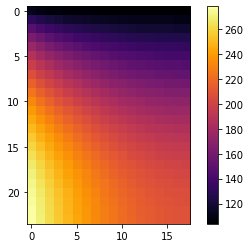

In [495]:
plt.imshow(sistema.get_solution().reshape((nvx,nvy)).T, cmap = "inferno")
plt.colorbar()

---

[Volver al índice](#Índice)

## Tres dimensiones

In [274]:
#-------------Definición de datos iniciales ----------------
lx = 0.5 # meters
ly = 0.5
lz = 0.5
TA = 100 # °C 
TB = 500 # °C 
k  = 1000 # W/m.K
nx = 5 # Número de volúmenes (5 volumenes tienen 6 fronteras)
ny = 5
nz = 6
#-------------------------------------------------------------

In [275]:
# ------------Creamos la malla de acuerdo a la geometría definida por el problema
malla = Mesh(3, volumes = (nx, ny, nz), lengths = (lx, ly, lz))
#-------------Definimos fronteras ----------
malla.tag_wall_neumann("W", TA)
malla.tag_wall_source("N", TA)
malla.tag_wall_dirichlet(["E", "S", "T", "B"], [TB, TB, TB, TA])
malla.draw()

---

[Volver al índice](#Índice)

## Problema condiciones iniciales

In [52]:
#------------- Initial data definition ----------------
lx = 1 # meters
TA = 0 # °C 
TB = 0 # °C 
k  = 1 # W/m.K 
nx  = 80# number of volumes
#-------------------------------------------------------------

In [53]:
# ------------Mesh definition and border conditions ----
malla = Mesh(1, volumes=nx,lengths=(lx,0.1,0.1))
#-------------Definimos fronteras ----------
malla.tag_wall_dirichlet('W',TA)
malla.tag_wall_dirichlet('E',TB)
malla.draw()

In [54]:
#--- creamos el objeto coeficientes --------------------------
coef = Coefficients(malla)
coef.set_diffusion(k)
print("\naP:")
print(coef.get_aP())
print("\nSp:")
print(coef.get_Sp())
print("\naE:")
print(coef.get_aE())
print("\naW:")
print(coef.get_aW())
# Agregamos una fuente con función dependiendo de las coordenadas
coef.add_source(lambda x: -np.cos(x))
print("\nSu:")
print(coef.get_Su())


aP:
[[[-3.2]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-1.6]]

 [[-3.2]]]

Sp:
[[[3.2]]

 [[0. ]]

 [[0. ]]

 [[0. ]]

 [[0. ]]

 [[0. ]]

 [[0. ]]

 [[0. ]]

 [[0. ]]

 [[0. ]]

 [[0. ]]



In [55]:
sistema = EqSystem(coef)
A = sistema.get_A_matrix()
print("La matriz que representa el sistema de ecuaciones es:\n", A)

La matriz que representa el sistema de ecuaciones es:
   (0, 0)	-3.2000000000000006
  (0, 1)	1.0666666666666669
  (1, 0)	0.8000000000000002
  (1, 1)	-1.6000000000000003
  (1, 2)	0.8000000000000002
  (2, 1)	0.7999999999999999
  (2, 2)	-1.5999999999999999
  (2, 3)	0.7999999999999999
  (3, 2)	0.8000000000000004
  (3, 3)	-1.6000000000000008
  (3, 4)	0.8000000000000004
  (4, 3)	0.8000000000000004
  (4, 4)	-1.6000000000000008
  (4, 5)	0.8000000000000004
  (5, 4)	0.7999999999999995
  (5, 5)	-1.599999999999999
  (5, 6)	0.7999999999999995
  (6, 5)	0.7999999999999995
  (6, 6)	-1.599999999999999
  (6, 7)	0.7999999999999995
  (7, 6)	0.8000000000000013
  (7, 7)	-1.6000000000000025
  (7, 8)	0.8000000000000013
  (8, 7)	0.7999999999999995
  (8, 8)	-1.599999999999999
  :	:
  (71, 71)	-1.5999999999999919
  (71, 72)	0.7999999999999959
  (72, 71)	0.7999999999999959
  (72, 72)	-1.5999999999999919
  (72, 73)	0.7999999999999959
  (73, 72)	0.800000000000003
  (73, 73)	-1.600000000000006
  (73, 74)	0.800000000

In [56]:
print("EL vector 'b' es:")
print(sistema.get_b_vector())

EL vector 'b' es:
[1.24997559e-04 1.24978028e-04 1.24938970e-04 1.24880390e-04
 1.24802298e-04 1.24704706e-04 1.24587629e-04 1.24451086e-04
 1.24295097e-04 1.24119688e-04 1.23924885e-04 1.23710719e-04
 1.23477223e-04 1.23224434e-04 1.22952392e-04 1.22661139e-04
 1.22350720e-04 1.22021184e-04 1.21672583e-04 1.21304970e-04
 1.20918404e-04 1.20512945e-04 1.20088655e-04 1.19645602e-04
 1.19183855e-04 1.18703486e-04 1.18204569e-04 1.17687183e-04
 1.17151409e-04 1.16597330e-04 1.16025032e-04 1.15434607e-04
 1.14826144e-04 1.14199741e-04 1.13555494e-04 1.12893504e-04
 1.12213875e-04 1.11516712e-04 1.10802126e-04 1.10070226e-04
 1.09321129e-04 1.08554950e-04 1.07771810e-04 1.06971831e-04
 1.06155137e-04 1.05321857e-04 1.04472121e-04 1.03606061e-04
 1.02723813e-04 1.01825514e-04 1.00911306e-04 9.99813301e-05
 9.90357325e-05 9.80746607e-05 9.70982650e-05 9.61066979e-05
 9.51001143e-05 9.40786716e-05 9.30425292e-05 9.19918491e-05
 9.09267955e-05 8.98475347e-05 8.87542354e-05 8.76470685e-05
 8.652

In [57]:
print(f"La solución es: {sistema.get_solution()}")

La solución es: [-0.00285362 -0.00844366 -0.01387749 -0.01915514 -0.02427669 -0.02924224
 -0.03405191 -0.03870584 -0.04320421 -0.04754721 -0.05173506 -0.055768
 -0.05964631 -0.06337027 -0.0669402  -0.07035644 -0.07361935 -0.07672932
 -0.07968677 -0.08249212 -0.08514585 -0.08764843 -0.09000036 -0.09220219
 -0.09425446 -0.09615774 -0.09791265 -0.09951981 -0.10097985 -0.10229346
 -0.10346131 -0.10448414 -0.10536267 -0.10609768 -0.10668993 -0.10714023
 -0.10744942 -0.10761835 -0.10764787 -0.1075389  -0.10729233 -0.10690912
 -0.10639021 -0.10573659 -0.10494925 -0.10402922 -0.10297753 -0.10179526
 -0.10048348 -0.09904329 -0.09747582 -0.09578221 -0.09396363 -0.09202125
 -0.08995628 -0.08776993 -0.08546345 -0.0830381  -0.08049515 -0.07783589
 -0.07506164 -0.07217374 -0.06917353 -0.06606237 -0.06284166 -0.05951278
 -0.05607717 -0.05253625 -0.04889148 -0.04514433 -0.04129626 -0.0373488
 -0.03330344 -0.02916173 -0.0249252  -0.02059541 -0.01617395 -0.01166239
 -0.00706234 -0.00237543]


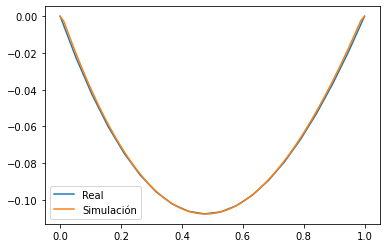

In [58]:
y = lambda x: 1 - np.cos(x) + (np.cos(1) - 1)*x
Γ_0 = Γ_1 = 0
x = np.linspace(0,1,nx+2)
x1 = np.linspace(0,1,20)
plt.plot(x1, y(x1))
plt.plot(x, [Γ_0] + list(sistema.get_solution()) + [Γ_1])
plt.legend(["Real", "Simulación"])
plt.show()

[Volver al índice](#Índice)